In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.coordinates import Angle

from gammapy.datasets import FluxPointsDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.modeling import Fit

from gammapy.estimators import FluxPointsEstimator

from feupy.utils.string_handling import name_to_txt
from feupy.utils.io import mkdir_sub_directory
from feupy.utils.coordinates import skycoord_config_to_skycoord as to_skycoord
from feupy.utils.observation import ObservationParameters
from feupy.utils.geometry import (
    create_energy_axis, 
    create_pointing, 
    create_pointing_position, 
    create_region_geometry,
    define_on_region,
)

from feupy.target import Target
from feupy.cta.irfs import Irfs
from feupy.analysis.config import AnalysisConfig
from feupy.analysis.core import Analysis

from core import load_source_model

In [ ]:
config = AnalysisConfig()
# source_name = 'Cen A'
source_name = 'Fornax A'
name_file = name_to_txt(source_name)

position = SkyCoord.from_name(source_name)
print(f'{position.ra.deg:.2f}, {position.dec.deg:.2f}')
print(f'{position.galactic.l.deg:.2f}, {position.galactic.b.deg:.2f}')
outdir = f"./{name_to_txt(source_name)}"
outdir_path = mkdir_sub_directory(outdir)

datasets_path = mkdir_sub_directory(outdir, 'datasets')[1]
figures_path = mkdir_sub_directory(outdir, 'figures')[1]
tables_path = mkdir_sub_directory(outdir, 'tables')[1]
data_path = mkdir_sub_directory(outdir, 'data')[1]

config.general.outdir = outdir
config.general.datasets_file = f'{datasets_path}/datasets.yaml'
config.general.models_file = f'{datasets_path}/models.yaml'

In [ ]:
from feupy.catalog import CATALOG_REGISTRY

catalog = CATALOG_REGISTRY.get_cls("4fgl")()
source = catalog[source_name]
print(source.info())

In [ ]:
redshift = 0.006010

In [5]:
datasets_path = f'{config.general.outdir}/datasets'
sky_model = load_source_model(datasets_path).copy()
display(sky_model.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str18
spectral,index,2.1479e+00,,4.432e-02,nan,nan,False,False,index@2FrDAmnF
spectral,amplitude,1.7451e-13,MeV-1 s-1 cm-2,1.133e-14,nan,nan,False,True,amplitude@5Hz4qIgw
spectral,reference,1.7758e+03,MeV,0.000e+00,nan,nan,True,False,reference@vE9k6tR6


In [6]:
model_intrinsic = sky_model.spectral_model.copy()
print(model_intrinsic)

PowerLawSpectralModel

  type      name     value    ... frozen is_norm        link       
-------- --------- ---------- ... ------ ------- ------------------
spectral     index 2.1479e+00 ...  False   False     index@2FrDAmnF
spectral amplitude 1.7451e-13 ...  False    True amplitude@5Hz4qIgw
spectral reference 1.7758e+03 ...   True   False reference@vE9k6tR6


In [7]:
target = Target(
    name=source_name, 
    pos_ra=position.ra, 
    pos_dec=position.dec,
    spectral_model=model_intrinsic,
    redshift = redshift,
    ebl_model_name= "dominguez",
)

print(target)


*** Basic info ***

Source name : Fornax A

*** Position info ***

RA: 50.674 deg
DEC: -37.208 deg

*** Spectral info ***

Spectrum type:  CompoundSpectralModel
alpha_norm: 1.0 +- 0 
redshift: 0.00601 +- 0 
index: 2.15 +- 0.04432153147185463 
amplitude: 1.75e-13 +- 1.1325137596913921e-14 MeV⁻¹ s⁻¹ cm⁻²
reference: 1.78e+03 +- 0.0 MeV



In [8]:
livetime = 50 * u.h

irfs_opt = ['North', 'AverageAz', '20deg', '50h']

In [9]:
offset = 0.5*u.deg
pointing_angle = 0*u.deg

model = target.sky_model

on_region_radius = Angle("0.11 deg")

In [10]:
obs_param = ObservationParameters(livetime, offset, pointing_angle, irfs_opt)

config.observation  = obs_param.dict
config.observation.target = target.dict

config.datasets.on_region = target.dict['position']
config.datasets.on_region.radius  = on_region_radius

In [11]:
e_edges_min = 1.0e-01*u.TeV
e_edges_max = 3.2e+01*u.TeV
nbin_edges = 12

In [12]:
config.datasets.geom.axes.energy.min = e_edges_min
config.datasets.geom.axes.energy.max = e_edges_max
config.datasets.geom.axes.energy.nbins = nbin_edges
config.datasets.geom.axes.energy.name = 'energy'
energy_settings = config.datasets.geom.axes.energy

config.datasets.geom.axes.energy_true.min =  3.2e-02*u.TeV
config.datasets.geom.axes.energy_true.max = 1.0e+02*u.TeV
config.datasets.geom.axes.energy_true.nbins = 15
config.datasets.geom.axes.energy_true.name = 'energy_true'
energy_true_settings = config.datasets.geom.axes.energy_true

energy_axis = create_energy_axis(
    energy_settings.min, 
    energy_settings.max, 
    energy_settings.nbins, 
    per_decade=True, 
    name=energy_settings.name
)

In [13]:
target.redshift

0.00601

In [14]:
# config.write(path=f'{outdir}/config.yaml', overwrite=True)

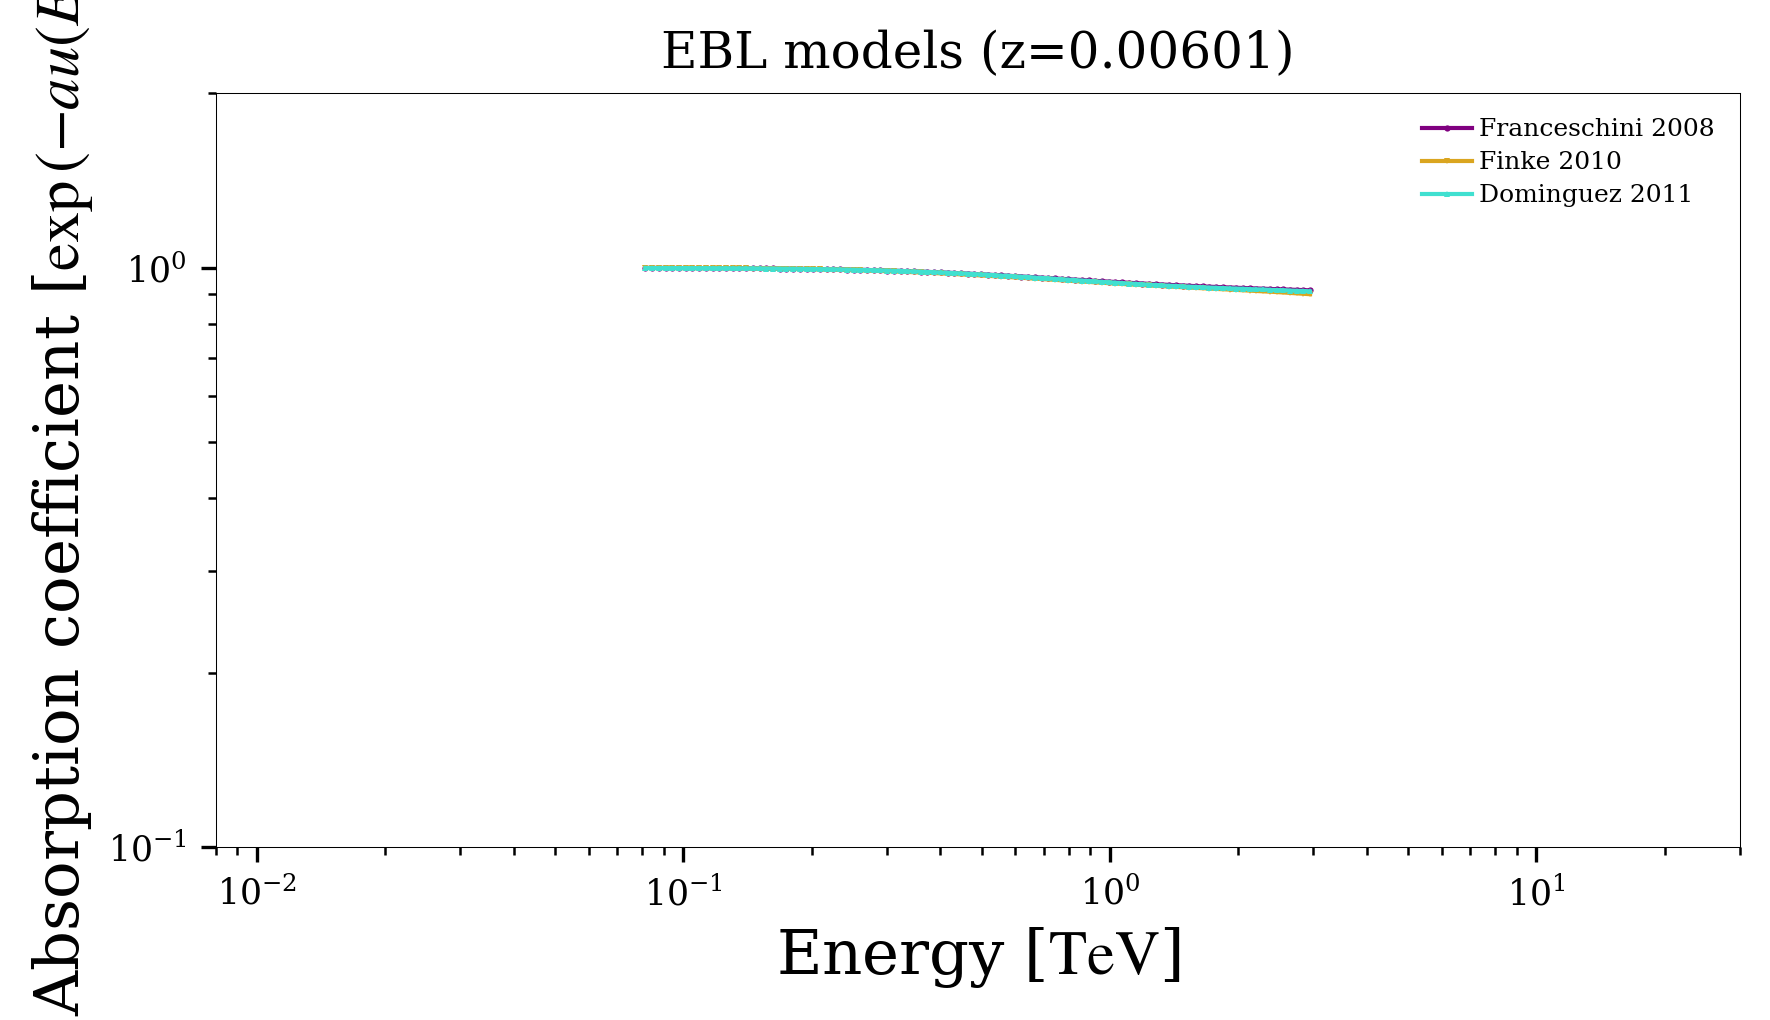

In [15]:
dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
franceschini = EBLAbsorptionNormSpectralModel.read_builtin("franceschini", redshift=redshift)
finke = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)

# start customised plot
energy_bounds = [0.08, 3] * u.TeV
ax = plt.gca()
opts = dict(energy_bounds=energy_bounds, ax=ax)
franceschini.plot(label='Franceschini 2008', **opts)
finke.plot(label='Finke 2010', **opts)
dominguez.plot(label='Dominguez 2011', **opts)

# tune plot
ax.set_ylabel(r'Absorption coefficient [$\exp{(-au(E))}$]')
ax.set_xlim([0.008, 30])  # we get ride of units
ax.set_ylim([1.e-1, 2.])
ax.set_yscale('log')
ax.set_title('EBL models (z=' + str(redshift) + ')')
plt.legend(loc='best') # legend

# show plot
plt.show()

In [16]:
# # start customised plot
# energy_bounds = [0.08, 3] * u.TeV
# ax = plt.gca()
# opts = dict(energy_bounds=energy_bounds, ax=ax)
# franceschini.plot(label='Franceschini 2008', **opts)
# finke.plot(label='Finke 2010', **opts)
# dominguez.plot(label='Dominguez 2011', **opts)

# # tune plot
# ax.set_ylabel(r'Absorption coefficient [$\exp{(-au(E))}$]')
# ax.set_xlim([0.008, 30])  # we get ride of units
# ax.set_ylim([1.e-1, 2.])
# ax.set_yscale('log')
# ax.set_title('EBL models (z=' + str(redshift) + ')')
# plt.legend(loc='best') # legend

# # show plot
# plt.show()

In [17]:
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

spectral_model = ebl * model_intrinsic
spatial_model = sky_model.spatial_model
model_simu = SkyModel(spectral_model=spectral_model, 
                      spatial_model=spatial_model,
                      name="model-simu")
display(model_simu.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,float64,float64,float64,bool,bool,str18
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,
spectral,index,2.1479e+00,,4.432e-02,nan,nan,False,False,index@2FrDAmnF
spectral,amplitude,1.7451e-13,MeV-1 s-1 cm-2,1.133e-14,nan,nan,False,True,amplitude@5Hz4qIgw
spectral,reference,1.7758e+03,MeV,0.000e+00,nan,nan,True,False,reference@vE9k6tR6


In [18]:
# irfs_groups =[
#     ['South', 'South-SSTSubArray','South-MSTSubArray','North','North-MSTSubArray', 'North-LSTSubArray'], 
#     ['AverageAz', 'SouthAz', 'NorthAz'], 
#     ['20deg','40deg','60deg'], 
#     ['0.5h', '5h', '50h']
# ]
# IRFS_OPTS, IRFS, IRFS_LABELS, LOCATION = Irfs.get_irf_groups(irfs_groups)

In [19]:
gamma_min = 10
n_sigma = 5 
bkg_syst_fraction = 0.10

containment = 0.68

acceptance = 1
acceptance_off = 20
config.onoff.acceptance = acceptance
config.onoff.acceptance_off = acceptance_off

In [20]:
n_obs = 10

In [21]:
map_selection = ["edisp", "background", "exposure"]
methods = ["bkg-peak"]
parameters = {'aeff_percent': 10}
containment_correction = False
use_region_center = False  

# map_selection = ["background", "edisp", "exposure"]
# methods = ["edisp-bias"]
# parameters = {'bias_percent': 10}

config.datasets.map_selection = map_selection
config.datasets.safe_mask.parameters = parameters
config.datasets.safe_mask.methods = methods
config.datasets.containment_correction = containment_correction
config.datasets.use_region_center = use_region_center
config.statistics.n_obs = n_obs

In [22]:
config.flux_points.source = target.name
config.flux_points.energy.nbins = config.datasets.geom.axes.energy.nbins
config.flux_points.energy.max = config.datasets.geom.axes.energy.max 
config.flux_points.energy.min = config.datasets.geom.axes.energy.min 

In [23]:
analysis = Analysis(config)
observation = analysis.create_observation()
reference_dataset = analysis.create_reference_dataset()
spectrum_dataset = analysis.simulate_spectrum(observation, reference_dataset, model.copy(name='source'))
dataset_on_off = analysis.make_on_off(spectrum_dataset)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Creating an observation

on_center:
<SkyCoord (ICRS): (ra, dec) in deg
    (50.67412083, -37.2082)>


pointing_position:
<SkyCoord (ICRS): (ra, dec) in deg
    (50.67412083, -36.7082)>


pointing:
FixedPointingInfo:

mode:        PointingMode.POINTING
coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (50.67412083, -36.7082)>


irfs label:
North (20deg-50h)


Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51546.08
	duration          : 180000.00 s
	pointing (icrs)   : 50.7 deg, -36.7 deg

	deadtime fraction : 0.0%


Creating an reference dataset
Creating maker and safe maker.
Running makers and safing.

Dataset Reduced:
SpectrumDataset
---------------

  Name                            : U33k03ZN 

  Total counts                    : 0 
  Total background counts         : 4615.87
  Total excess counts             : -4615.87

  Predicte

/home/born-again/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/home/born-again/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


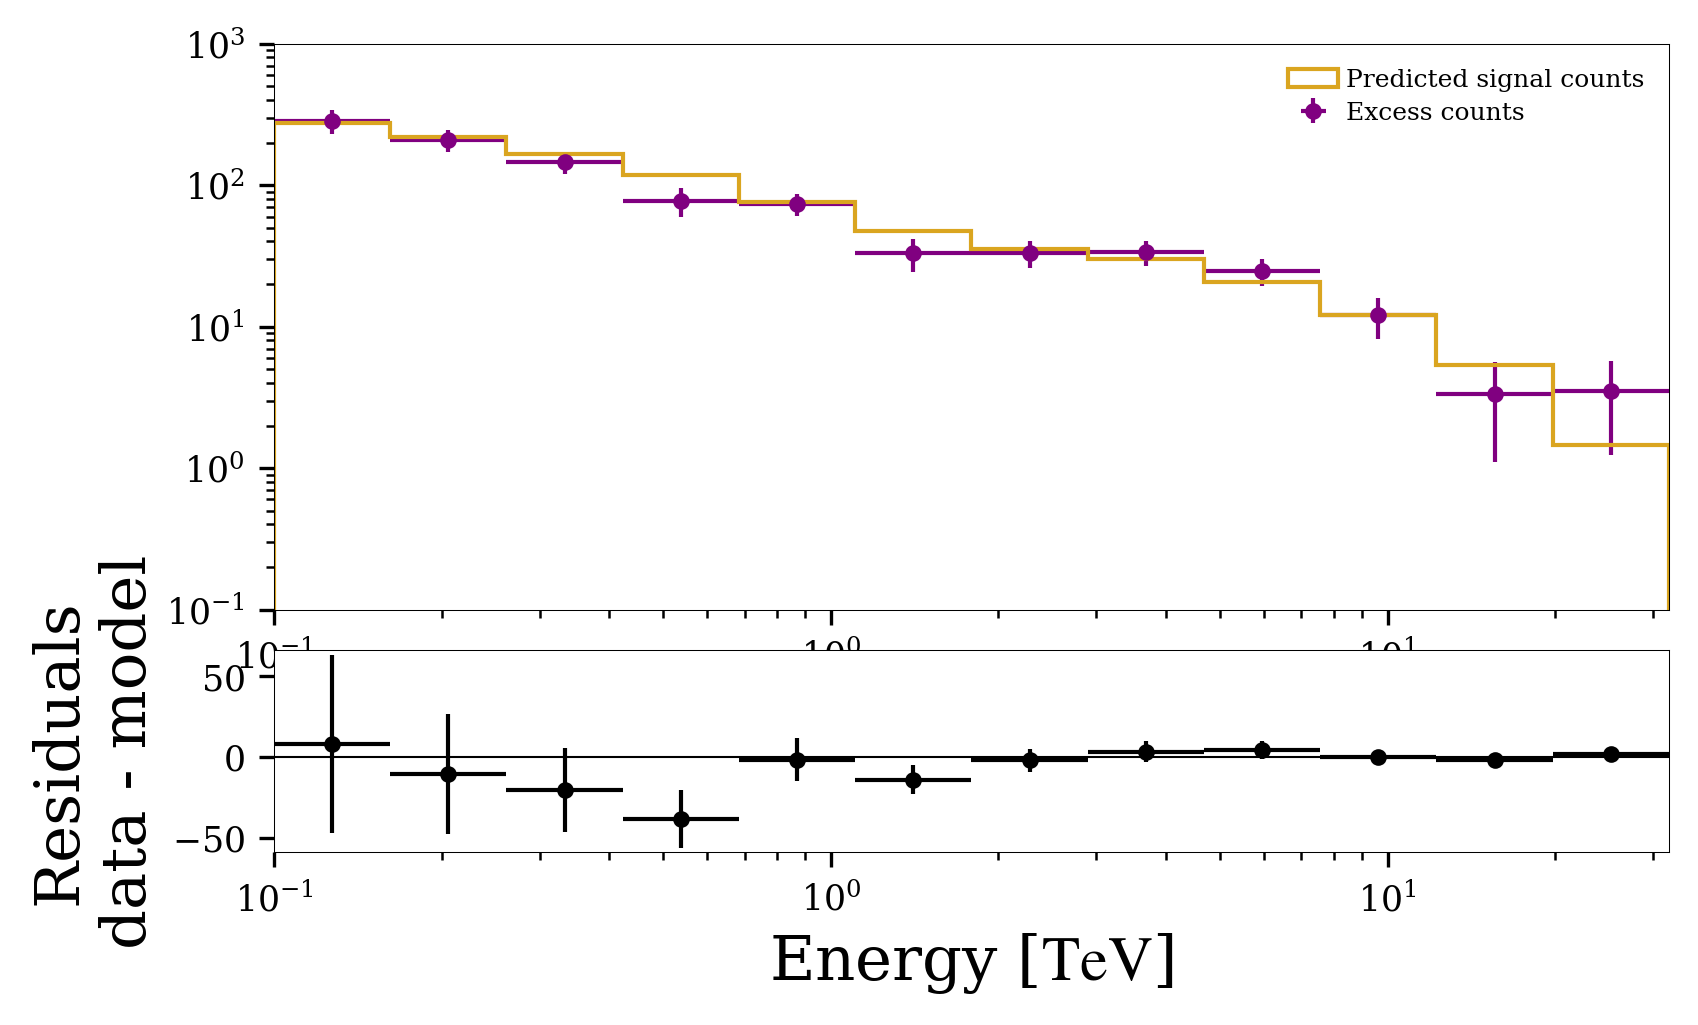

In [24]:
plt.figure()
ax_spectrum, ax_residuals = dataset_on_off.plot_fit()

In [25]:
simulated_datasets = analysis.run_on_off(spectrum_dataset, dataset_on_off)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,5649,1024.7001953125,14.183087845701497,4624.2998046875,4673.095304413854,4673.095304413854,nan,5436946944.0,171232182272.0,180000.0,180000.0,0.03138333333333333,0.025690554470486113,0.005692778862847222,12,12,wstat,391.284356629597,92486,12.0,240.00001525878906,0.04999999701976776
obs-1,5547,909.8999999999987,12.62596212002215,4637.100000000001,4680.428571428572,4680.428571428572,nan,5436946792.545327,171232178141.60303,180000.0,180000.0,0.030816666666666666,0.025761666666666672,0.005054999999999993,12,12,wstat,335.3839467703303,92742,12.0,239.99999999999991,0.05000000000000002
obs-2,5537,924.0,12.846937724285533,4613.0,4656.999999999999,4656.999999999999,nan,5436946792.545327,171232178141.60303,180000.0,180000.0,0.03076111111111111,0.025627777777777777,0.0051333333333333335,12,12,wstat,357.487517229564,92260,12.0,240.0,0.05
obs-3,5589,988.6499999999987,13.733740186513106,4600.350000000001,4647.428571428571,4647.428571428571,nan,5436946792.545327,171232178141.60303,180000.0,180000.0,0.03105,0.025557500000000007,0.005492499999999993,12,12,wstat,362.7636461031368,92007,12.0,239.99999999999991,0.05000000000000002
obs-4,5713,1070.000000000001,14.760257280421843,4642.999999999999,4693.95238095238,4693.95238095238,nan,5436946792.545327,171232178141.60303,180000.0,180000.0,0.031738888888888886,0.02579444444444444,0.005944444444444449,12,12,wstat,473.12828387869615,92860,12.0,240.00000000000006,0.04999999999999999
obs-5,5548,921.6999999999989,12.798651458114927,4626.300000000001,4670.190476190475,4670.190476190475,nan,5436946792.545327,171232178141.60303,180000.0,180000.0,0.030822222222222223,0.02570166666666667,0.005120555555555549,12,12,wstat,413.80066848470176,92526,12.0,239.99999999999994,0.05000000000000001
obs-6,5642,1033.1499999999996,14.318350832946942,4608.85,4658.047619047619,4658.047619047619,nan,5436946792.545327,171232178141.60303,180000.0,180000.0,0.031344444444444446,0.025604722222222223,0.00573972222222222,12,12,wstat,468.73907581637286,92177,12.0,240.0,0.05
obs-7,5589,979.4499999999989,13.597419063944074,4609.550000000001,4656.190476190477,4656.190476190477,nan,5436946792.545327,171232178141.60303,180000.0,180000.0,0.03105,0.025608611111111117,0.005441388888888883,12,12,wstat,409.1121402543595,92191,12.0,239.99999999999994,0.05000000000000001


In [26]:
simulated_datasets.models = [model.copy('source')]
print(simulated_datasets.models)

DatasetModels

Component 0: SkyModel

  Name                      : source
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.006                   
    index@2FrDAmnF                :      2.148   +/-    0.04             
    amplitude@5Hz4qIgw            :   1.75e-13   +/- 1.1e-14 1 / (MeV s cm2)
    reference@vE9k6tR6    (frozen):   1775.844       MeV         




In [27]:
results = []
fit = Fit()
for dataset in simulated_datasets.copy():
    # Do the 3D fit
    model_fit = model.copy(name="model-simu")
    spectral_model = model_fit.spectral_model
#     spectral_model.lambda_.min = 0
    dataset.models = [model_fit]

    fit_result = fit.run([dataset])

    if fit_result.success:
        _par_dict = {}
        _par_dict["irfs_opt"] = f'{irfs_opt}'
        _par_dict["success"] = fit_result.success

        for par in fit_result.parameters.free_parameters:
            _par_dict[par.name] = par.quantity

        sp_model = fit_result.models["model-simu"].spectral_model
        results.append(_par_dict)

In [28]:
flux_points_settings = analysis.config.flux_points
energy_settings = flux_points_settings.energy

In [29]:
energy_edges = MapAxis.from_energy_bounds(
    energy_settings.min,
    energy_settings.max, 
    nbin=energy_settings.nbins).edges

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, 
    source='source', 
    selection_optional="all"
)
flux_points = fpe.run(datasets=simulated_datasets)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

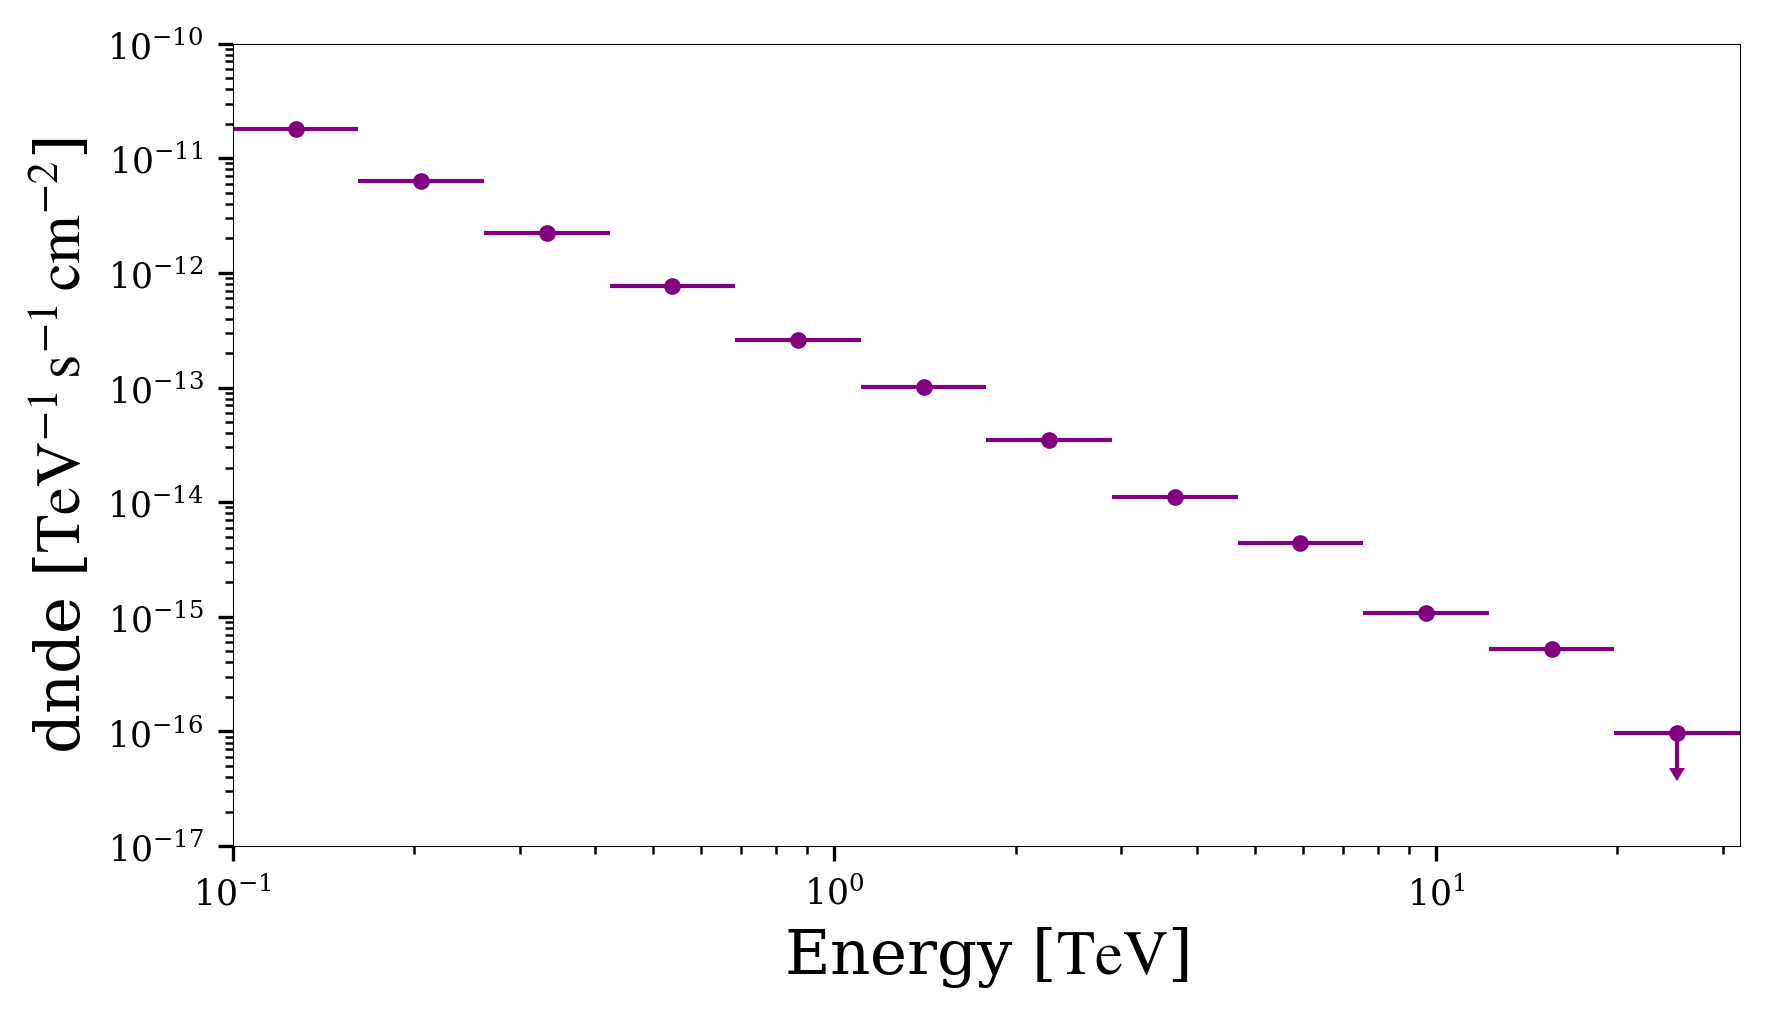

In [30]:
flux_points.plot()

In [31]:
dataset_cta = FluxPointsDataset(models=model_fit, data=flux_points, name=Irfs.get_irfs_label(irfs_opt))

(<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals\n (data - model) / model'>)

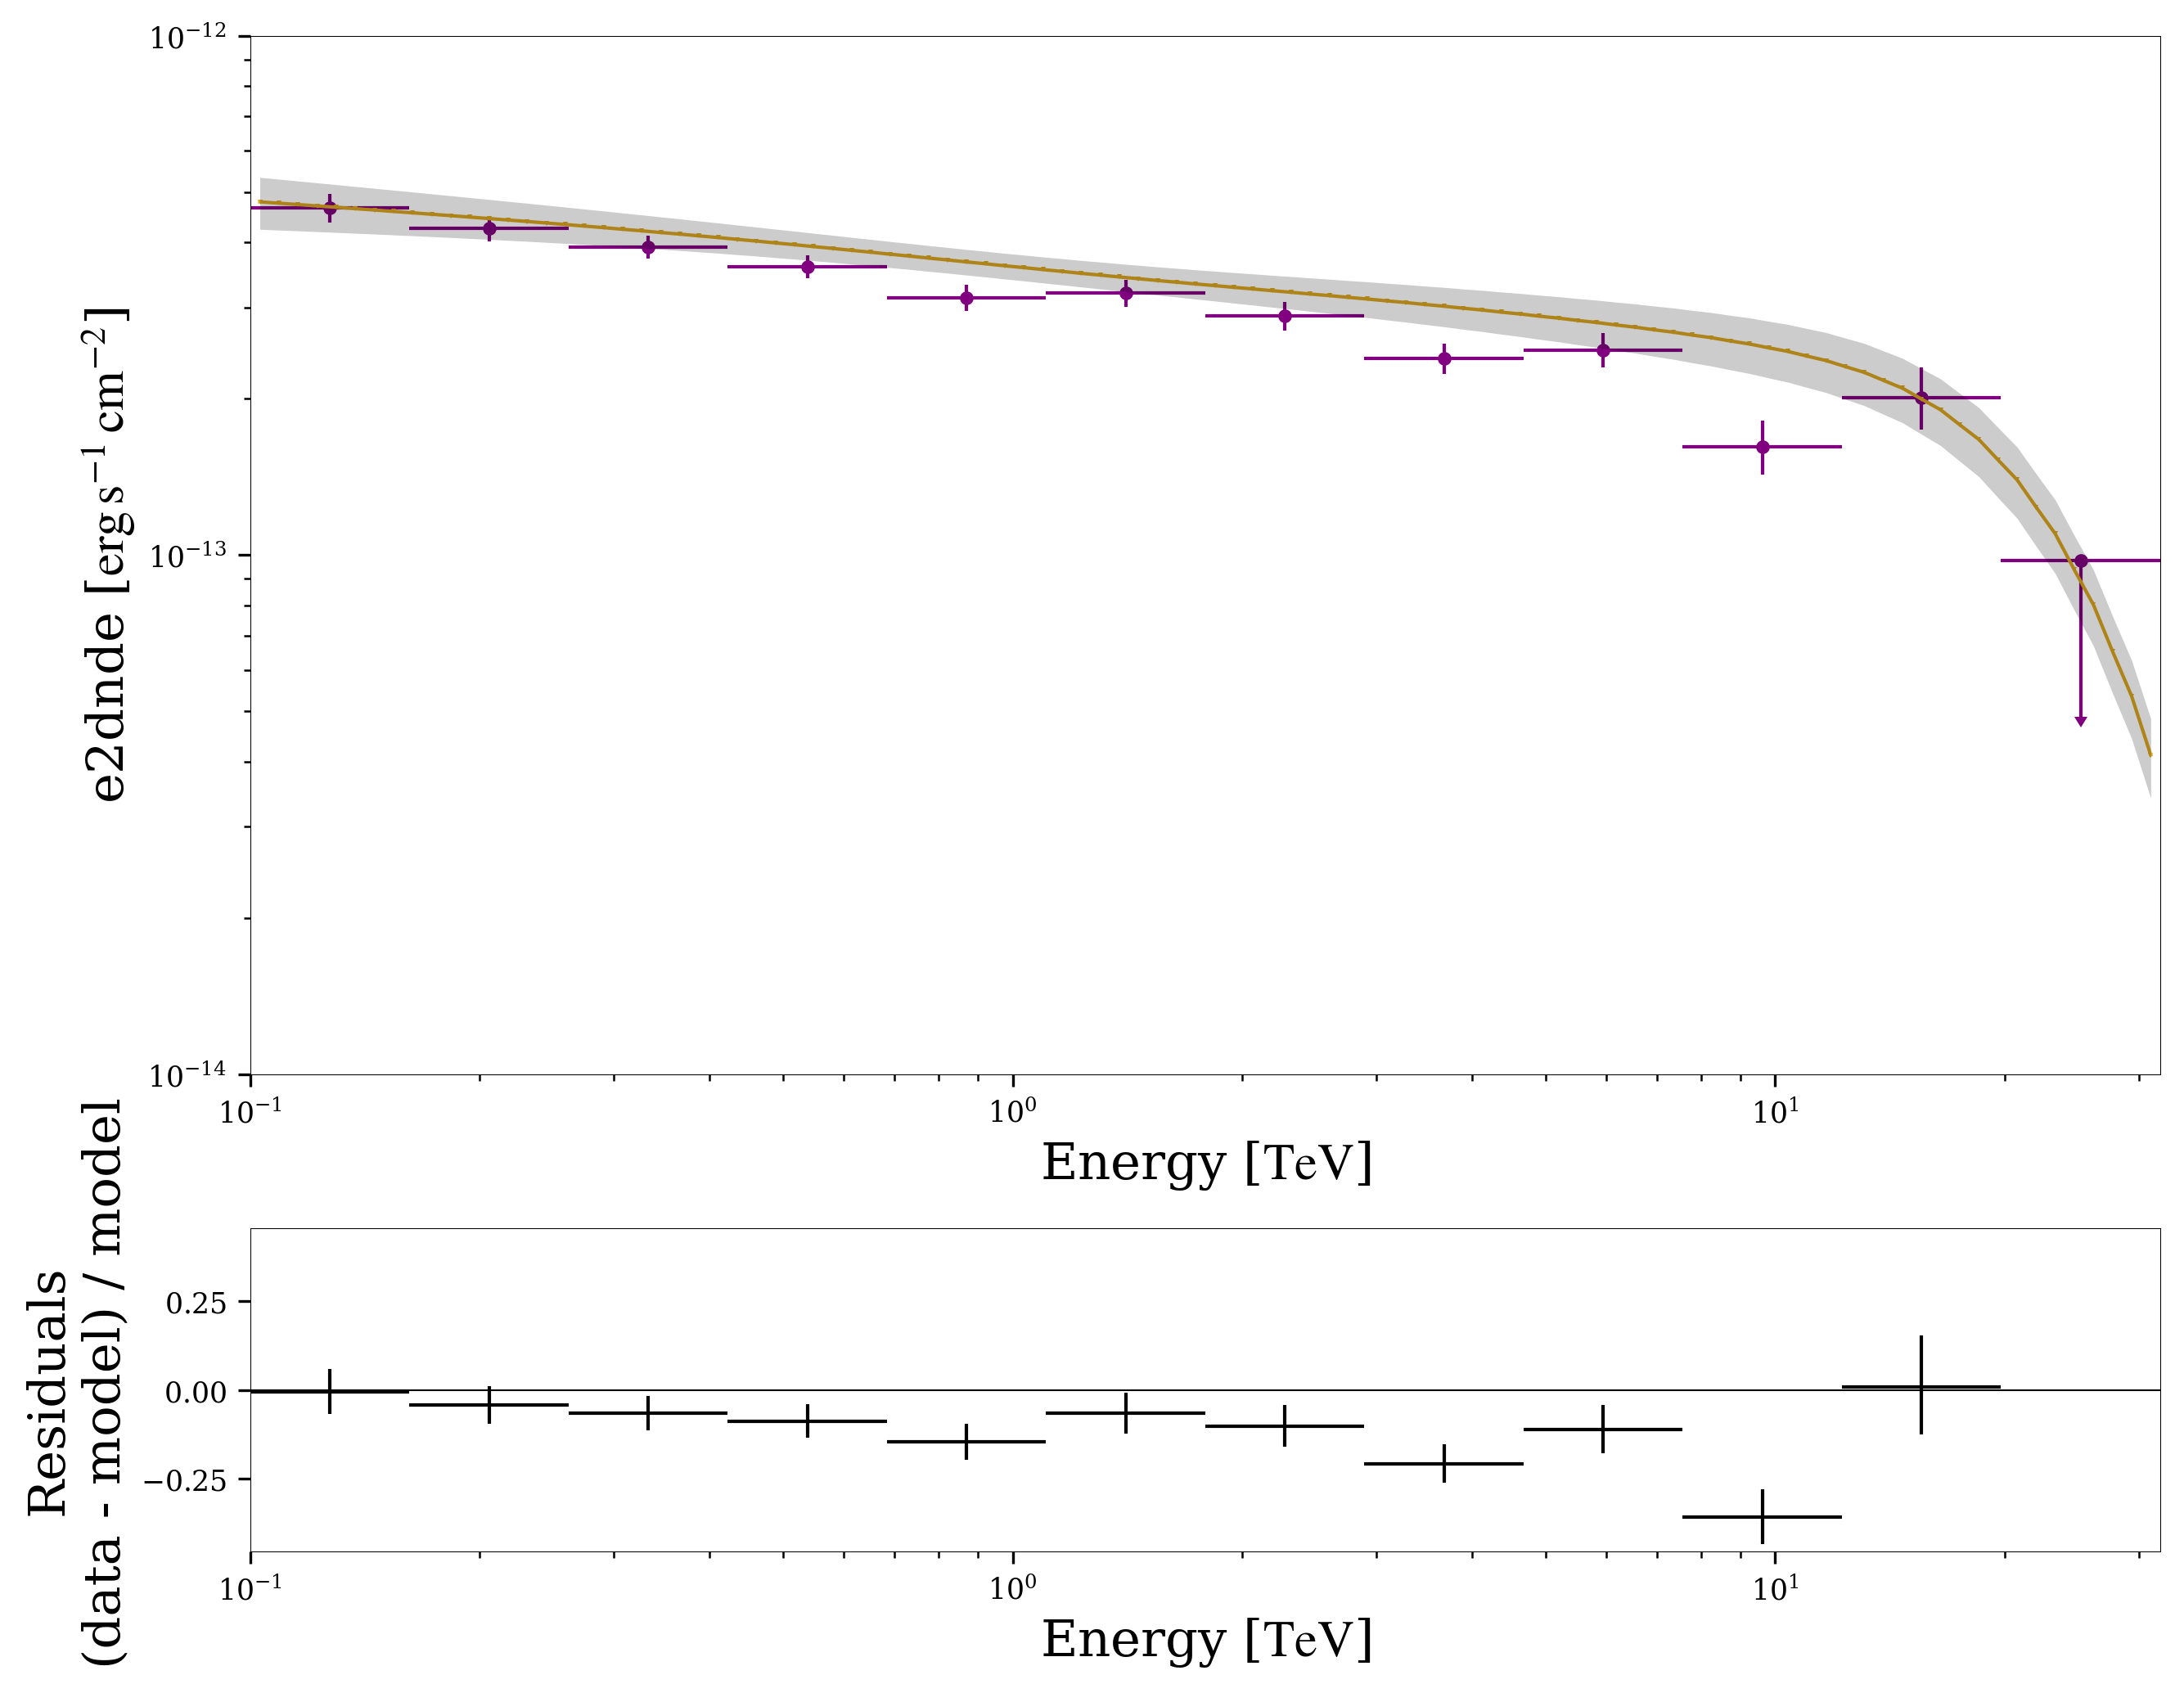

In [32]:
dataset_cta.plot_fit()

In [33]:
path_dir = datasets_path
datasets_HE = Datasets.read(filename=f'{path_dir}/datasets.yaml', filename_models=f'{path_dir}/models.yaml')


NameError: name 'Datasets' is not defined

In [ ]:
from feupy.plotters import generate_marker_set 

In [ ]:
datasets = Datasets(datasets_HE[0:3])
datasets.append(dataset_cta)

xaxis_label = r'$\rm{E\ [MeV] }$'
xaxis_units = u.Unit('MeV')

yaxis_label = r'$\rm{E^2\ J(E)\ [erg\ cm^{-2}\ s^{-1}] }$'
yaxis_units = u.Unit('erg cm-2 s-1')

energy_bounds = [1e1, 1e9] * u.MeV
ylim = [1e-15, 1e-8]

leg_place = dict(
#     bbox_to_anchor = (1, 0.5), # Set legend outside plot
    ncol=1, 
    loc='upper left', 
)
markers = generate_marker_set(datasets.names, 5)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for index, d in enumerate(datasets):
    marker=markers['marker'][index] 
    label=markers['label'][index] 
    markersize=markers['markersize'][index] 
    color=markers['color'][index] 

    d.data.plot(
        label=d.name, 
        c=color,
        marker=marker,
        markersize=markersize,
        ls='None',
        mec='k',
        mew=0.5,
        elinewidth=0.7,
        capsize=1.5,
        **kwargs
    )
    
model_fit.spectral_model.plot(energy_bounds=energy_bounds, label=model_fit.name, color="k", **kwargs)
model_fit.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.yaxis.set_units(yaxis_units)
ax.xaxis.set_units(xaxis_units)

ax.set_xlabel(xaxis_label)
ax.set_ylabel(yaxis_label)

ax.set_xlim(energy_bounds)
ax.set_ylim(ylim)

ax.legend(**leg_place)

plt.title(f"{source_name}")

plt.savefig(f"{figures_path}/SED_HE_CTA_{name_file}")
plt.show()
